## Pre-requisite: Library requirements

In [1]:
# # !nvidia-smi
%pip install numpy
%pip install matplotlib
%pip install glob
%pip install os 
%pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#!nvidia-smi
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import glob
import os

In [3]:
%ls
%ls ../data
%ls ../data/frac_map | head -10

0_Cluster_Rivers.jpeg/                   8523-Ying.ipynb*
8523_Common.ipynb*                       8523_Ying_UCL_Experiments.ipynb
8523_data_processing_70.ipynb            8523_Ying_UCL_Experiments-Task1.ipynb
8523_data_processing_80.ipynb            core.3755254*
8523_data_processing_90.ipynb            core.3779393*
8523_data_processing_kmeans_taks1.ipynb  core.3780321*
8523_Shonal2.ipynb*                      explanation.jpg*
8523-Shonal.ipynb*                       model_training_history.png
8523-Tanisha.ipynb*                      README.md*
8523_Task2_RTL_Exp_100_317.ipynb*        Shonal3.ipynb*
8523_Task2_RTL_Exp_70_2726.ipynb         Shonal4.ipynb*
8523_Task2_RTL_Exp_90_1940.ipynb         Shonal5.ipynb*
8523_Task2_UCL_Exp_100_317.ipynb         Shonal6_visualization.ipynb*
8523_Task2_UCL_Exp_70_2726.ipynb         Shonal7_fixing80.ipynb
8523_Task2_UCL_Exp_90_1940.ipynb         split_dataset.ipynb*
8523_Task2_UCL_Pipeline_Testing.ipynb*   TODO For Task 2
8523_Task2_Visualization.i

In [4]:
fracmaps_dir = '../data/frac_map'
frac_maps = os.listdir(fracmaps_dir)
timeseries_dir = '../data/time_series'
time_series = os.listdir(timeseries_dir)

total_maps = len(frac_maps) # 26754
total_ts = len(time_series) # 26754
print("total_maps len is ", total_maps, "total_ts len is ", total_ts)

## save fraction map and time series into img arrays
for i in range(0, total_maps):
    fm = frac_maps[i]
    frac_maps[i] = np.load(os.path.join(fracmaps_dir, fm), allow_pickle=True)
    ts = time_series[i]
    time_series[i] = np.load(os.path.join(timeseries_dir, ts), allow_pickle=True)
    

print(frac_maps[0].shape) ## (1,64,64)
print(time_series[0].shape) ## (442, 1)

total_maps len is  26754 total_ts len is  26754
(1, 64, 64)
(442, 1)


In [5]:
t = os.listdir('../data/frac_map')
t[0]

'ID_742140_frac_map.npy'

In [6]:
ID_labels = '../label_info/all_IDs_labels.npy'
ID_labels = np.load(ID_labels, allow_pickle=True)

# size of all labels
print(ID_labels.shape) ## (1000000,)

# check size of each label
# print(np.where(ID_labels==0)[0].shape) # (979799,) - unknown
# print(np.where(ID_labels==1)[0].shape) # (427,) - farm
# print(np.where(ID_labels==2)[0].shape) # (18707,) - reservoir
# print(np.where(ID_labels==3)[0].shape) # (317,) - river
# print(np.where(ID_labels==4)[0].shape) # (143,) - stable lakes
# print(np.where(ID_labels==5)[0].shape) # (288,) - seasonal lakes
# print(np.where(ID_labels==6)[0].shape) # (52,) - highly seasonal lakes
# print(np.where(ID_labels==7)[0].shape) # (255) - ephemeral lakes
# print(np.where(ID_labels==8)[0].shape) # (12,) - river runoff/oxbow

# fm_river_labels = np.where(ID_labels==3)[0]
# fm_river_labels
# print(fm_river_labels)
# fname = '../data/frac_map/ID_409869_frac_map.npy'
# s = np.load(fname, allow_pickle=True)
# river_0 = np.squeeze(s, axis = 0)
# plt.imshow(river_0)

(1000000,)


#### - Save all river fraction maps in the fm_rivers and river time series in the ts_rivers array

In [7]:
# extract river from fraction maps and time series maps
river_ids = np.where(ID_labels==3)[0]
print(river_ids.shape) # 317
#fracmaps_dir = '../data/frac_map'
#timeseries_dir = '../data/time_series'
fm_rivers = []
ts_rivers = []
pre = 'ID_'
fm_post = '_frac_map.npy'
ts_post = '_time_series.npy'

for sid in river_ids:
    fm_name = pre + str(sid) + fm_post
    ts_name = pre + str(sid) + ts_post
    fm_path = os.path.join(fracmaps_dir, fm_name)
    ts_path = os.path.join(timeseries_dir, ts_name)
    fm_rivers.append(np.load(fm_path, allow_pickle=True))
    ts_rivers.append(np.load(ts_path, allow_pickle=True))
#     print(np.load(ts_path, allow_pickle=True).shape) # (442,1)

fm_rivers = np.array(fm_rivers)
ts_rivers = np.array(ts_rivers)
print(fm_rivers.shape) # should be 317
print(ts_rivers.shape) # should be 317

# visualize the first river fraction map
# river_0 = np.squeeze(fm_rivers[0], axis = 0)
# plt.imshow(river_0)

(317,)
(317, 1, 64, 64)
(317, 442, 1)


# Preprocessing frac_maps

Currently, we have 26754 fraction maps. Each of these is of shape 1x64x64. Let's change that to 64x64 and aggregate them all into one array where each value is tuple in the form (name of file, 64x64 array)

In [8]:
fms = [] # fraction map: contains each 26754 64*64 array

for i in range(0, len(frac_maps)):
    fms.append(frac_maps[i][0])
    
fms = np.array(fms)
# print(fms[0])
# plt.imshow(fms[0])

In [9]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle
import re
import cv2
from kmeanstf import KMeansTF

2022-12-18 18:59:07.145506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 18:59:09.440241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /panfs/jay/groups/6/csci8523/lu000097/.local/lib/python3.7/site-packages/cv2/../../lib64:/panfs/roc/msisoft/cuda/10.0/lib64
2022-12-18 18:59:09.440285: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-18 18:59:18.026700: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:6

In [10]:
fm_filename = os.listdir('../data/frac_map') # has a 1-1 mapping with fms => fm_filename[i] is the filename of fms[i]
print(fm_filename[0])
ID_labels[0] # ID_labels is the ground truth array, len = 100,0000, ID_labels[ID] = class_no, ID is from filename

ID_742140_frac_map.npy


0

#### x_train is fms[i] which is a 64*64 2d array, y_train is ID_labels[getID(fm_filename, i)] which is a number

In [11]:
# a helper function which gets the ID of a fraction map array given the idx

def getID(fm_fn, idx):
    fn = fm_fn[idx] # get the file name
    fm_id = int(re.findall(r'\d+', fn)[0])
    return fm_id

getID(fm_filename, 1)

741138

In [12]:
y_train = []
for i in range(0, len(fms)):
    y_train.append(ID_labels[getID(fm_filename, i)])

y_train = np.array(y_train)
print(len(y_train))
print(np.unique(y_train))

26754
[0 1 2 3 4 5 6 7 8]


In [13]:
## check y_train label distribution 
print(np.where(y_train==0)[0].shape)
print(np.where(y_train==1)[0].shape)
print(np.where(y_train==2)[0].shape)
print(np.where(y_train==3)[0].shape)
print(np.where(y_train==4)[0].shape)
print(np.where(y_train==5)[0].shape)
print(np.where(y_train==6)[0].shape)
print(np.where(y_train==7)[0].shape)
print(np.where(y_train==8)[0].shape)

(24682,)
(427,)
(578,)
(317,)
(143,)
(288,)
(52,)
(255,)
(12,)


Since data is already between 0 to 1 we do not require normalization.

In [14]:
print(fms.shape)
print(y_train.shape)
print(fms[0].shape)
print(y_train[1])

(26754, 64, 64)
(26754,)
(64, 64)
7


In [15]:
# Reshaping input data
X_train = fms.reshape(len(fms),-1)
#X_test = x_test.reshape(len(x_test),-1)
print(X_train.shape)
# training, 

(26754, 4096)


The output is (26754, 4096). (64 x 64 = 4096)

## Setting the data

In [16]:
# numpy.random.shuffle(fms)
# training, test = fms[:80,:], dictionary[80:,:]
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(fms, y_train, test_size=0.2, random_state=42)
# print(X_train[0].shape) # 64*64
# print(X_train.shape) # 64*64

In [37]:
labeled = [] # has labels 1,2,3,4,5,6,7,8
y_labeled = [] # corresponding label
unlabeled = [] # anything else (24682, )
x_river = [] # holding rivers 317

x_other = [] # 
y_other = []

print(len(fms)) # 26754 , 0 - 8

for i in range(0, len(fms)):

    label = ID_labels[getID(fm_filename, i)]
    
    if (label == 3):
        x_river.append(fms[i])

    elif (label == 0): # unknown 
        unlabeled.append(fms[i])
    else:
        x_other.append(fms[i])
        y_other.append(label)
        labeled.append(fms[i])
        y_labeled.append(label)
      
    
labeled = np.array(labeled)
unlabeled = np.array(unlabeled)
x_river = np.array(x_river)
x_other = np.array(x_other)


print(labeled.shape)
print(len(y_labeled))
print(unlabeled.shape)
print(x_river.shape)


print(x_other.shape)
print(len(y_other))

# # save into data/ying_unlabeled_train folder
# for i in range(0, len(unlabeled)):
#     img_name = "../data/ying_unlabeled_train/" + str(i) + ".jpeg"
#     matplotlib.image.imsave(img_name, unlabeled[i])

    
# # save into data/ying_labeled_test folder
# for i in range(0, len(labeled)):
#     img_name = "../data/ying_labeled_test/" + str(i) + ".jpeg"
#     matplotlib.image.imsave(img_name, labeled[i])

26754
(1755, 64, 64)
1755
(24682, 64, 64)
(317, 64, 64)
(1755, 64, 64)
1755


## Minibatch Kmeans

In [18]:
### training dataset: unlabeled
### river test dataset: x_river, y_labeled
print(unlabeled.shape)
kmeans_xtrain = unlabeled.reshape(len(unlabeled),-1)
print(kmeans_xtrain.shape)

(24682, 64, 64)
(24682, 4096)


In [19]:
# kmeans 
from sklearn.cluster import MiniBatchKMeans
total_clusters = 2 # river vs non-river
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = 2)
# Fitting the model to training set
kmeans.fit(kmeans_xtrain)

labels = kmeans.labels_
print(labels)

[1 1 0 ... 0 0 0]


In [20]:
# visualize 2 clusters to see which one is more likely to be river cluster 
cluster0_ids = np.where(labels==0)[0]
print(len(cluster0_ids)) # 8688 in cluster 0 

cluster1_ids = np.where(labels==1)[0]
print(len(cluster1_ids)) # 15994 in cluster 0 



15849
8833


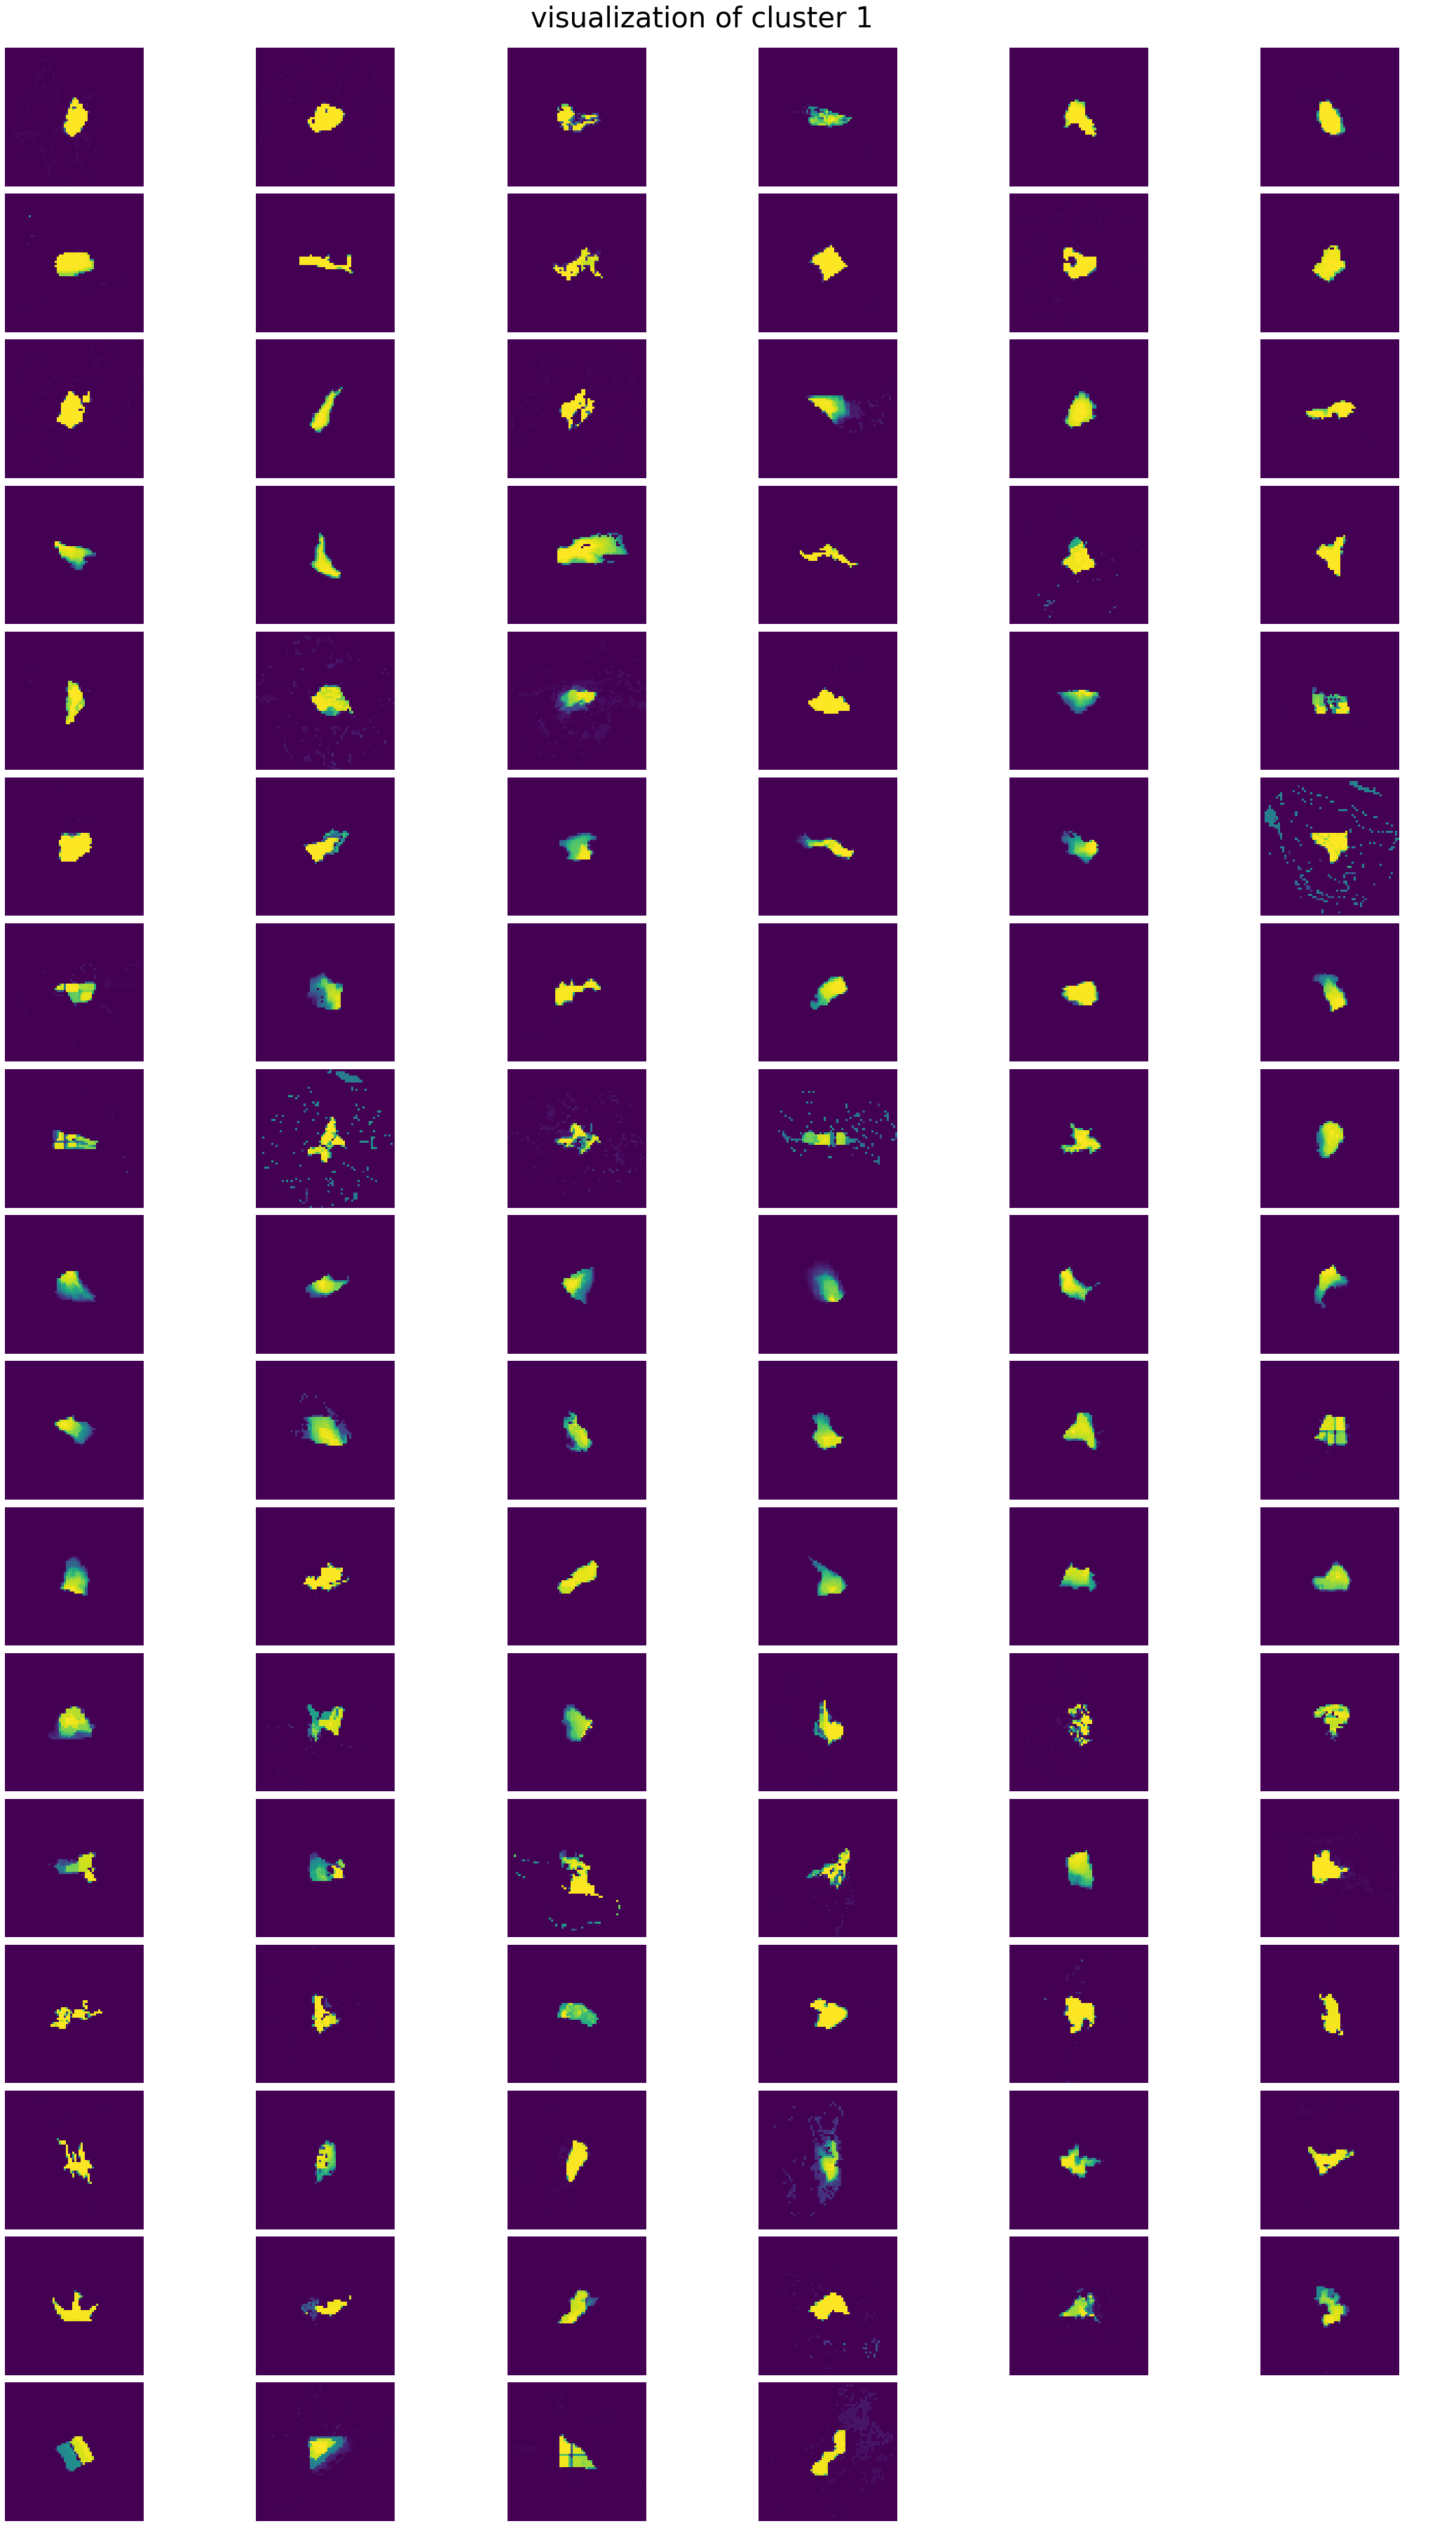

In [21]:
# visualize 
# img_arr = kmeans_xtrain[cluster1_ids[0]]
# print(img_arr.shape)
# img_arr = img_arr.reshape(64,64)
# l = len(cluster0_ids)
l = 100
cols = 6

rows = (l//cols) + 1

fig, axes = plt.subplots(rows, cols, figsize=(30,50))
fig.suptitle("visualization of cluster 1",y=1.0,fontsize=40,ha='center')
ax = axes.ravel()
for i in range(0, l):
    im = (kmeans_xtrain[cluster1_ids[i]]).reshape((64,64))
    ax[i].imshow(im)

for a in ax:
        a.set_axis_off()

plt.tight_layout()
plt.show()  

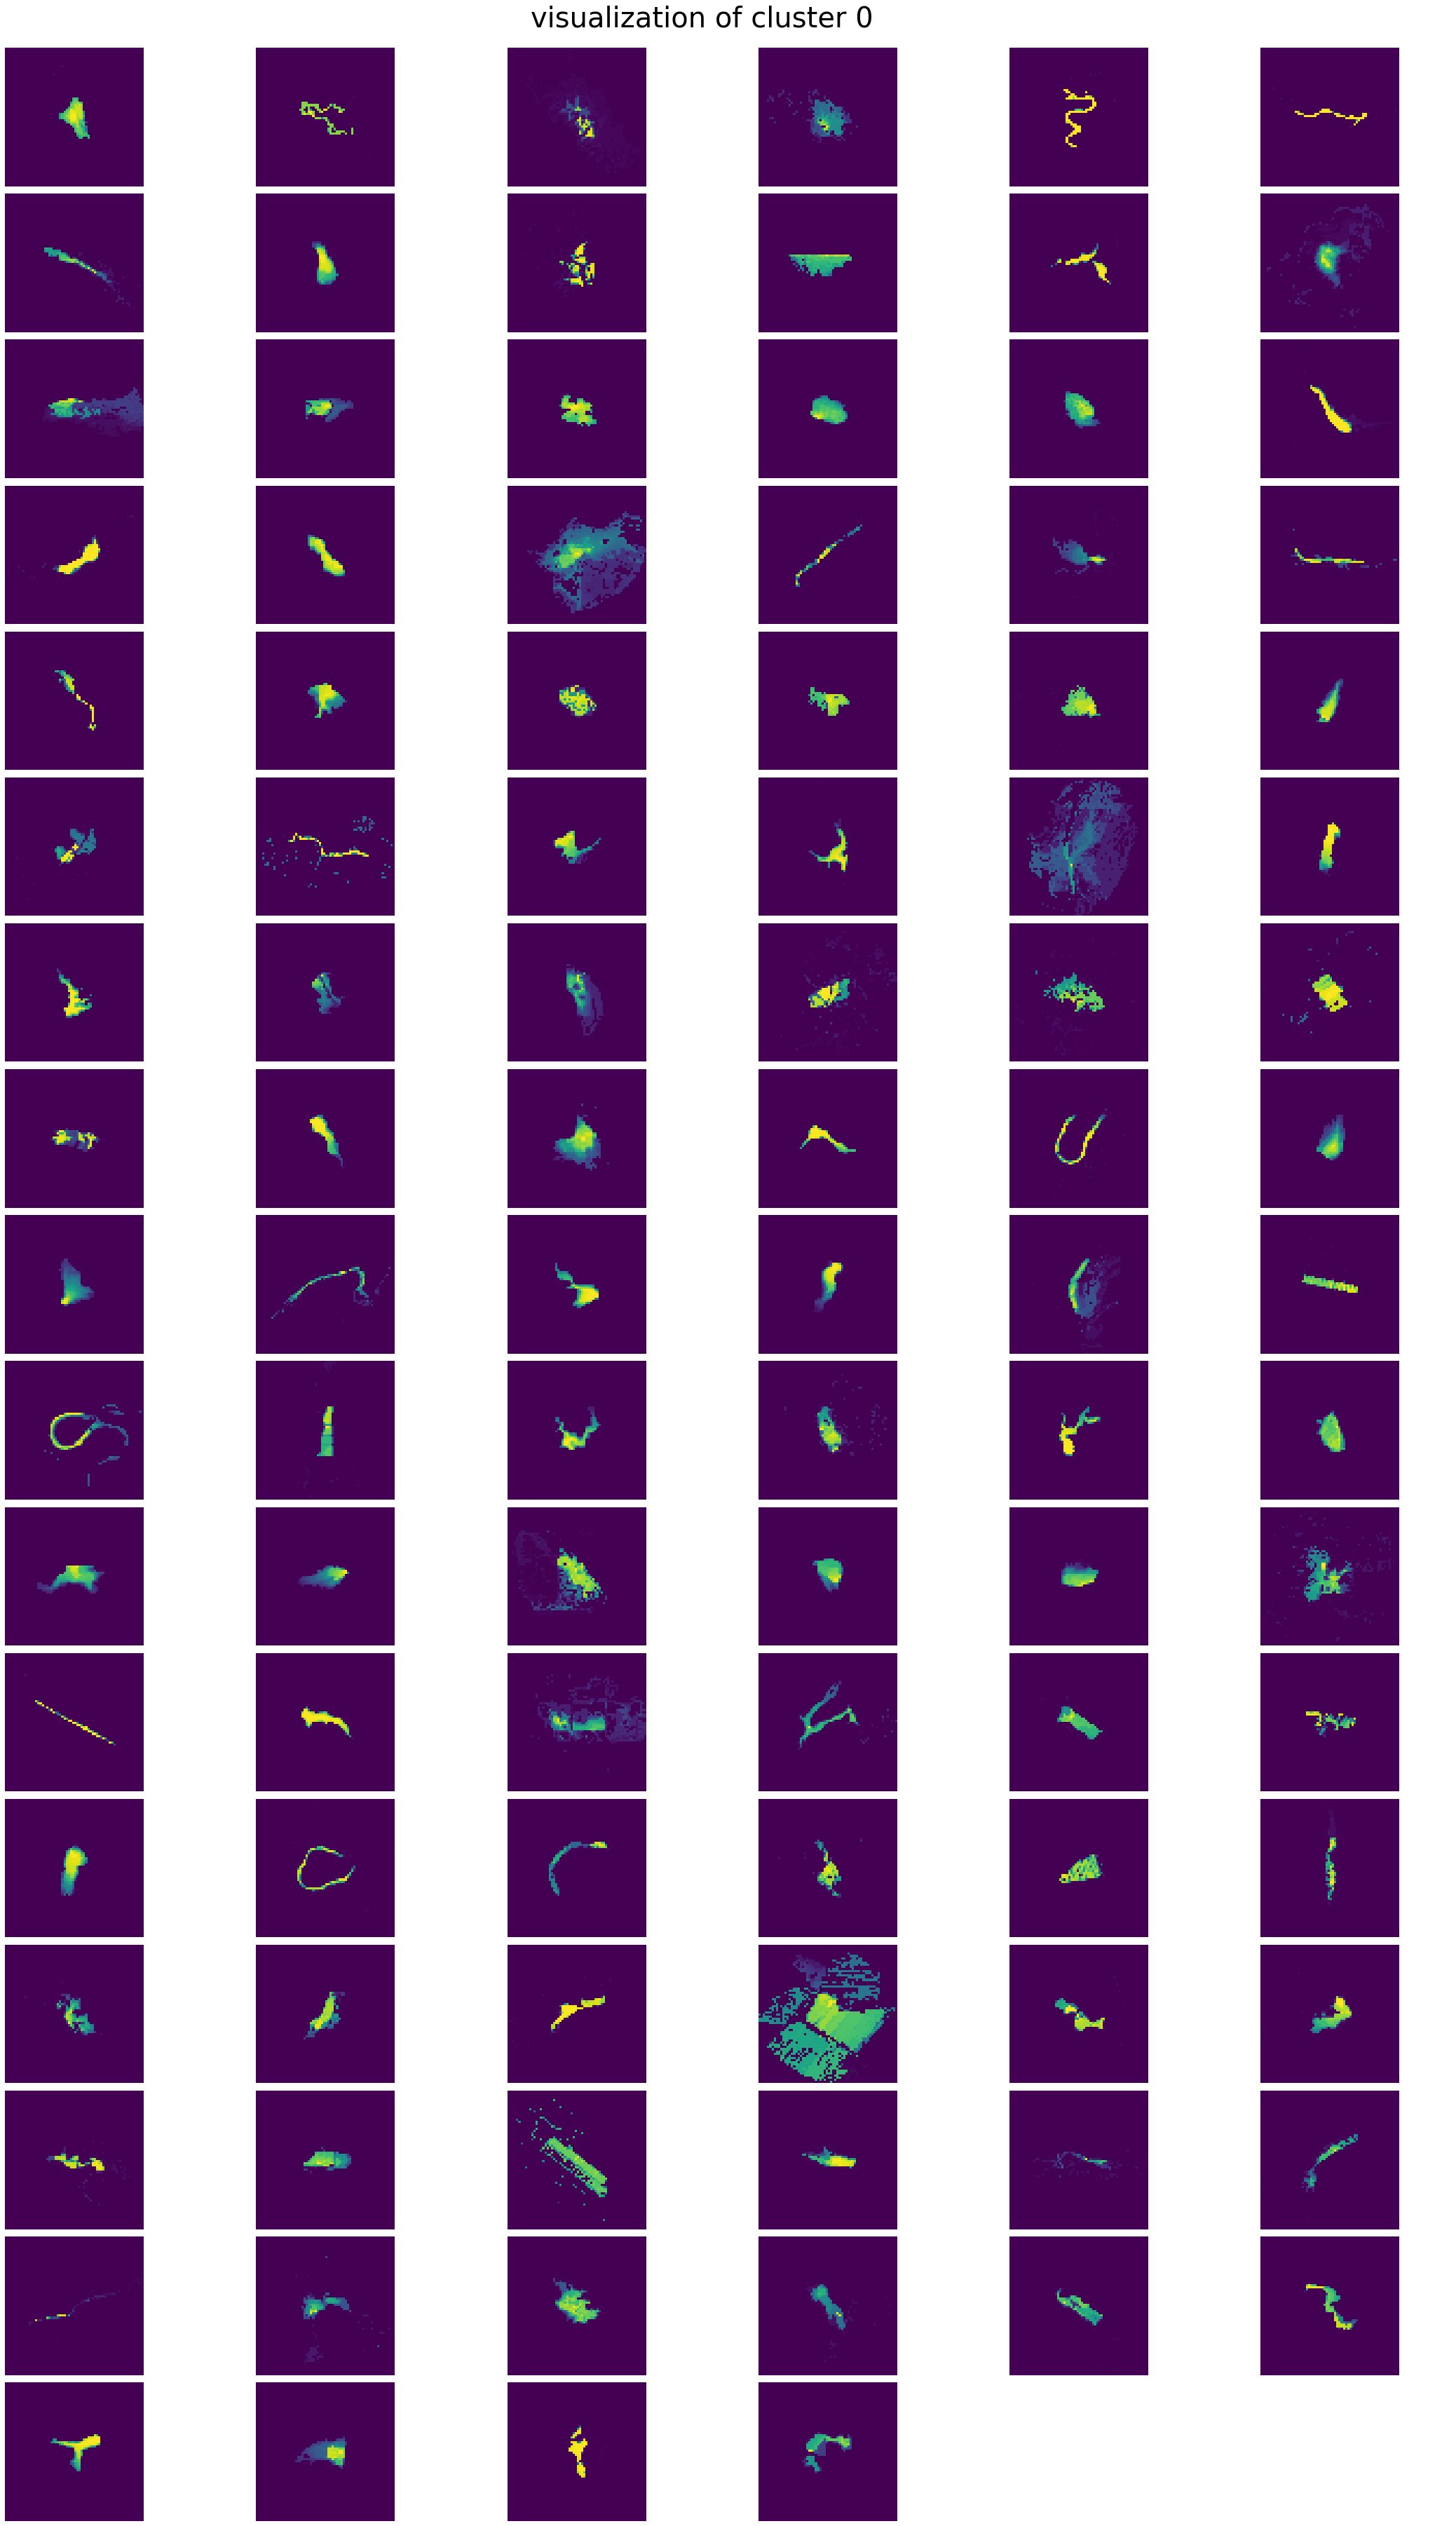

In [22]:
l = 100
cols = 6

rows = (l//cols) + 1

fig, axes = plt.subplots(rows, cols, figsize=(30,50))
fig.suptitle("visualization of cluster 0",y=1.0,fontsize=40,ha='center')
ax = axes.ravel()
for i in range(0, l):
    im = (kmeans_xtrain[cluster0_ids[i]]).reshape((64,64))
    ax[i].imshow(im)

for a in ax:
        a.set_axis_off()

plt.tight_layout()
plt.show() 

In [23]:
# l = 100
# cols = 5

# rows = (l//cols) + 1



# fig, axes = plt.subplots(rows, cols, figsize=(50,50))
# fig.suptitle("visualization of labeled rivers",y=1.0,fontsize=40,ha='center')
# ax = axes.ravel()
# for i in range(0, l):
#     im = x_river[i]
#     ax[i].imshow(im)

# for a in ax:
#         a.set_axis_off()

# plt.tight_layout()
# plt.show() 

In [39]:
## predict on test dataset and calculate accuracy
kmeans_xtest = x_river.reshape(len(x_river), -1)
kmeans_xtest2 = x_other.reshape(len(x_other), -1)
print(kmeans_xtest.shape) # 317
print(kmeans_xtest2.shape) # 1755

pred_labels = kmeans.predict(kmeans_xtest2)

print(len(pred_labels)) # 317

(317, 4096)
(1755, 4096)
1755


In [43]:
# cluster 0 is river
river_labels = [1] * len(pred_labels) # not river
# river_labels = [0] * n
# print(river_labels)
print(len(river_labels))
print(pred_labels)
# for i in range (0, 1755):
#     print(pred_labels[i])

1755
[0 0 0 ... 0 0 0]


In [47]:
from sklearn.metrics import accuracy_score

# It counts the undefined into consideration, may need to remove those data points for computing accuracy
print(accuracy_score(pred_labels, river_labels))

0.33048433048433046


In [45]:
pred_labels2 = kmeans.predict(kmeans_xtest)

print(len(pred_labels2)) # 317

# cluster 0 is river
river_labels2 = [0] * len(pred_labels2) # not river
# river_labels = [0] * n
# print(river_labels)
print(len(river_labels2))
print(pred_labels2)
# for i in range (0, 1755):
#     print(pred_labels[i])

317
317
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [46]:
from sklearn.metrics import accuracy_score

# It counts the undefined into consideration, may need to remove those data points for computing accuracy
print(accuracy_score(pred_labels2, river_labels2))

1.0


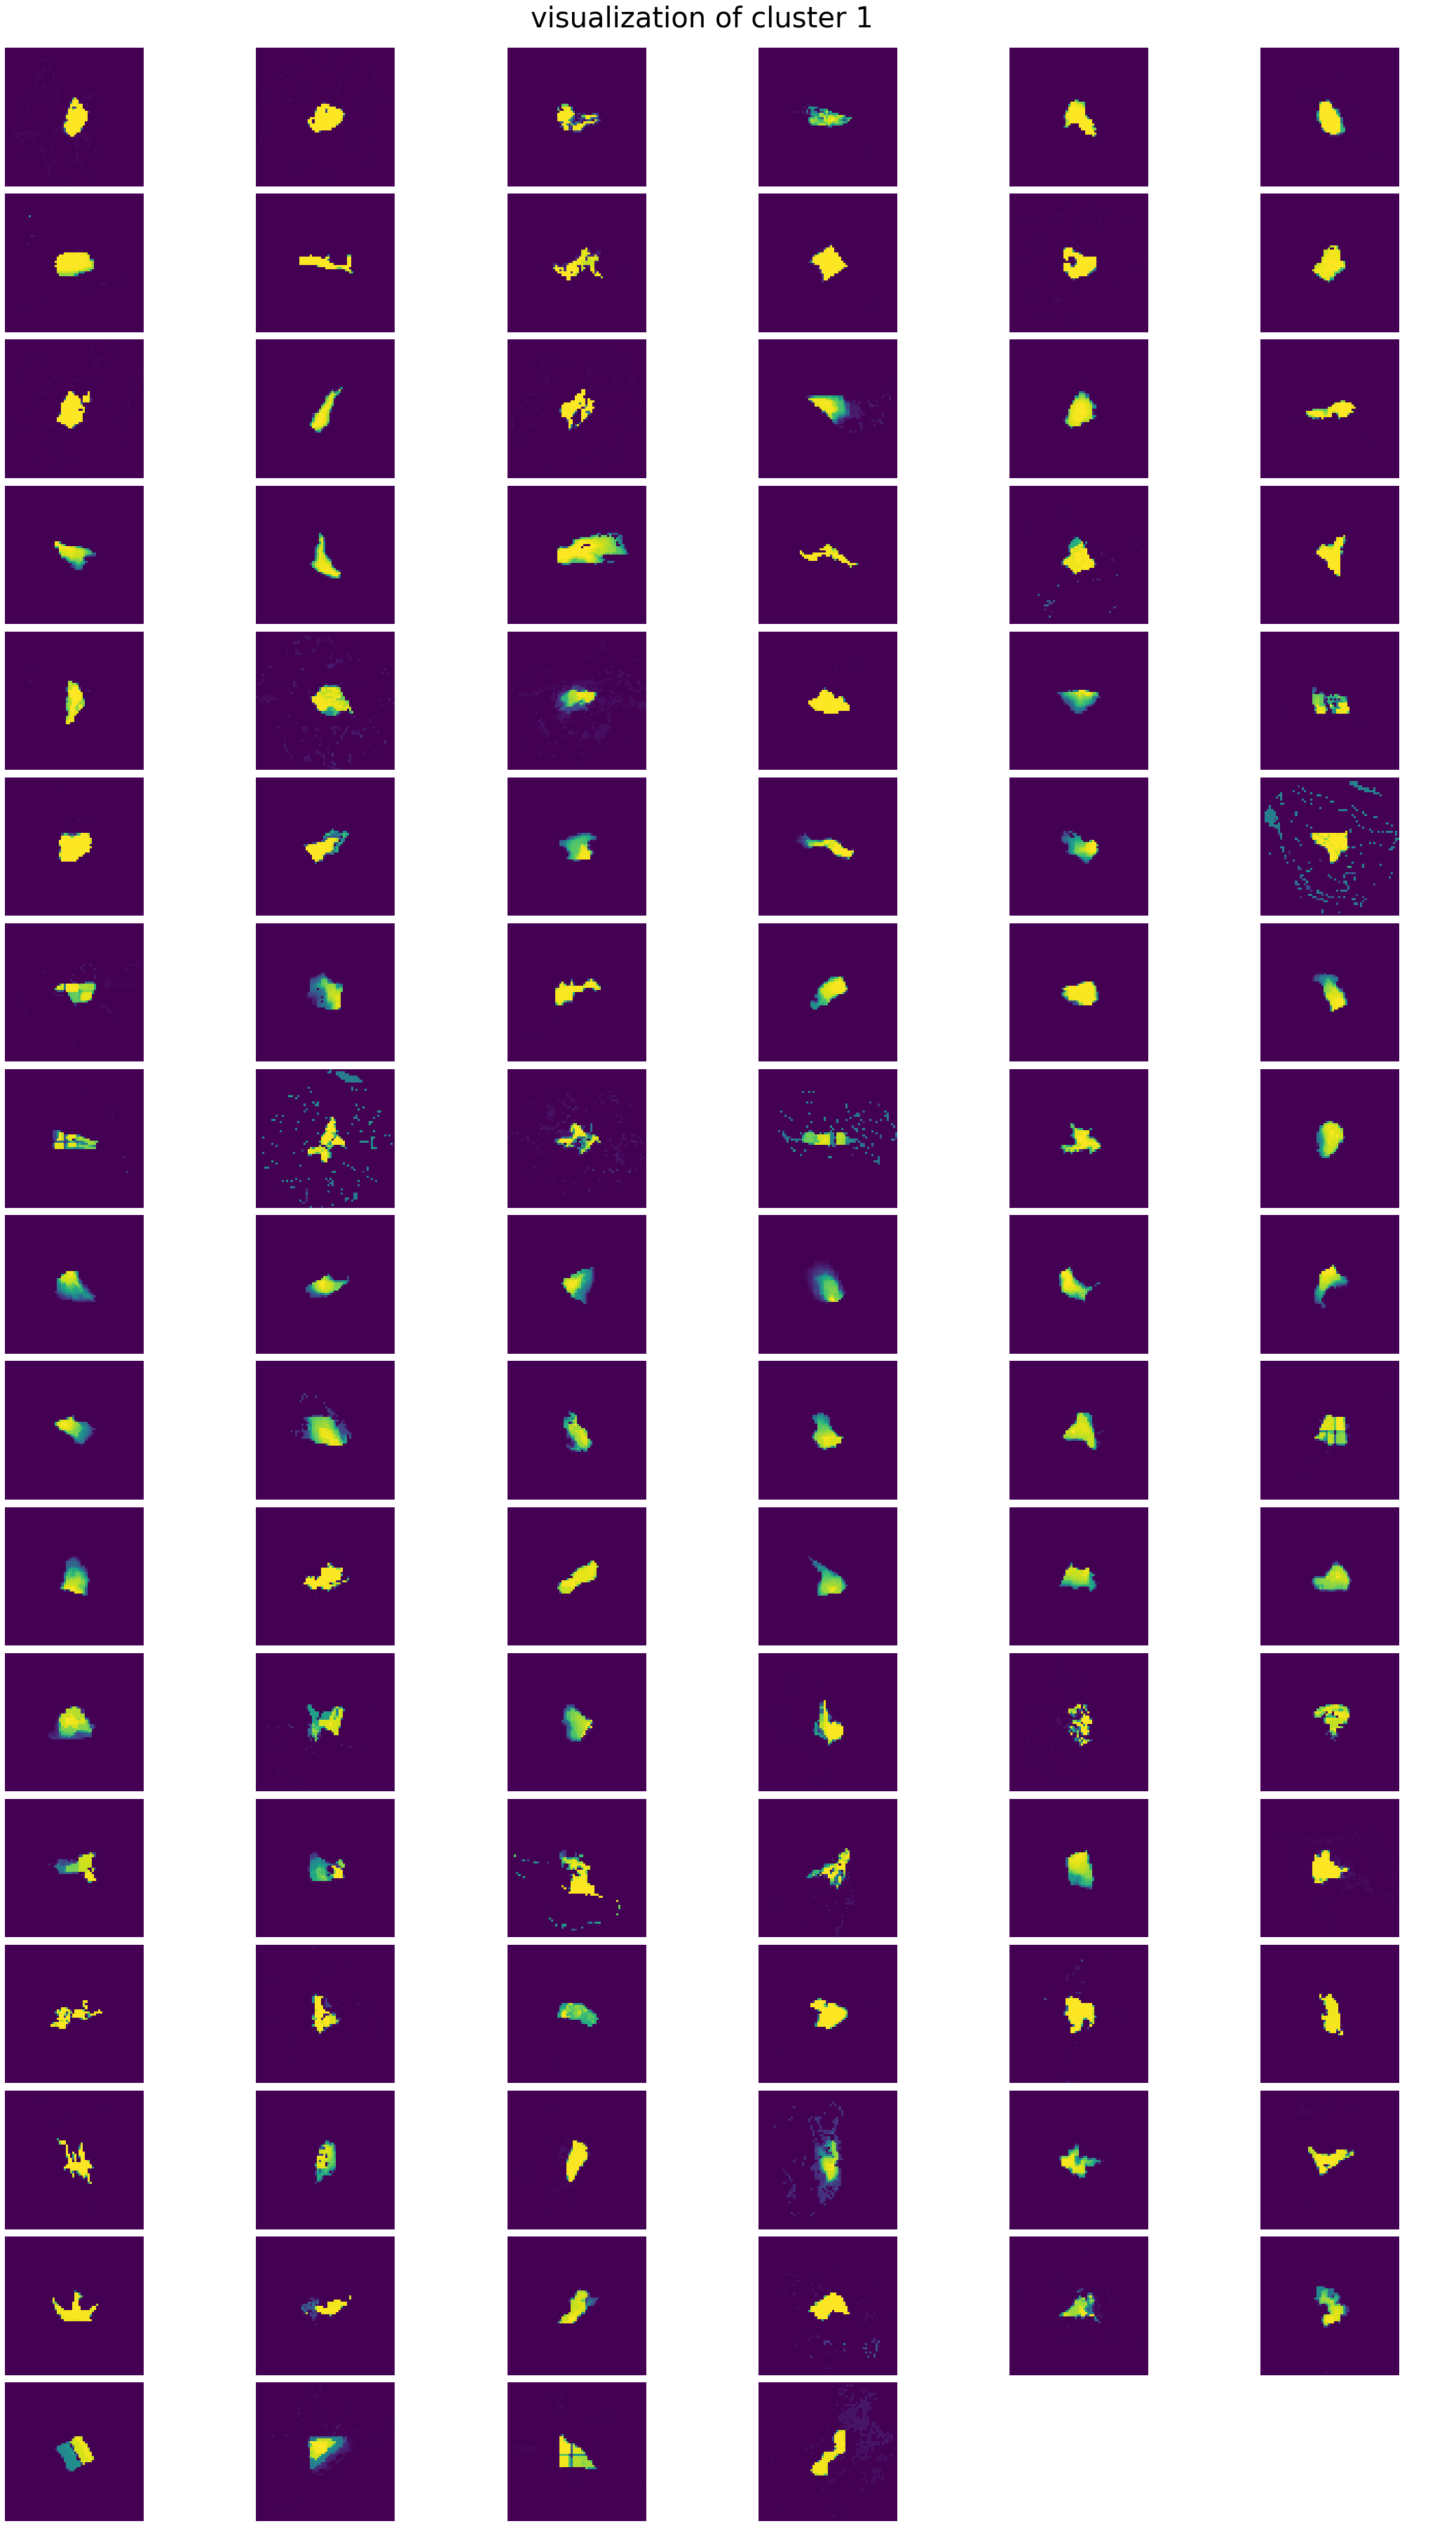

In [27]:
l = 100
cols = 6

rows = (l//cols) + 1

fig, axes = plt.subplots(rows, cols, figsize=(30,50))
fig.suptitle("visualization of cluster 1",y=1.0,fontsize=40,ha='center')
ax = axes.ravel()
for i in range(0, l):
    im = (kmeans_xtrain[cluster1_ids[i]]).reshape((64,64))
    ax[i].imshow(im)

for a in ax:
        a.set_axis_off()

plt.tight_layout()
plt.show()  